# Example: Machine configuration
This notebook describes the process of creating a machine configuration file for use by FreeGSNKE.

A machine description in FreeGSNE is comprised of:
- active coils (that can have their voltages modulated for controlling the plasma shape and position, among other things).
- passive structures (that make up the tokamak vessel, coil cans, support structures etc.)
- limiter/wall (that are non-conducting surfaces used to constrain the plasma boundary).

In the following, we build up each of these elements into the structures required by FreeGSNKE and save them for later use.

## Import packages

In [1]:
import numpy as np
import pickle

## Active coils
First, we define the characteristics that make up the *active coils* in our tokamak. Begin by defining the resistivity of the material that the active coils are made of.

In [2]:
eta_copper = 1.55e-8  # Resistivity in Ohm*m

Now we specify the geometry of the coils. The following variables define the locations of five coils named: `P1_lower`, `P1_upper`, `P2_lower`, `P2_upper` and `Pz`. Each coil contains two windings (one upper and one lower).

We've also made a shortcut and assumed that `P1_lower` and `P1_upper` have the same radial position and are equally distanced from the midplane in the vertical direction. The same applies to `P2_lower` and `P2_upper`.

In [3]:
# P1_lower and P1_upper windings radial positions
P1_r = [0.75, 0.77]

# P1_upper windings vertical positions
P1_upper_z = [1.1, 1.12]

# P1_lower and P1_upper width and height
P1_dr = 0.02
P1_dz = 0.02

# As above, but for the P2_lower and P2_upper coils
P2_r = [1.75, 1.77]
P2_upper_z = [0.6, 0.62]
P2_dr = 0.02
P2_dz = 0.02

# Finally, the Pz coil
Pz_r = [1.75, 1.75]
Pz_z = [0.0, 0.0]
Pz_dr = 0.02
Pz_dz = 0.02

Next, we populate a Python dictionary (here called `active_coils_dict`) with these values.

Each entry to the dictionary should be another dictionary describing a coil. This dictionary can take one of two forms:  
1. one with the keys described below, or
2. one with labels corresponding to multiple coils.

This format allows for standalone coils or groups of coils to be defined. We first demonstrate the standalone coil `Pz`, then show how `P1_upper` and `P1_lower` can be grouped, and again for `P2_upper` and `P2_lower`.

The keys for the coil dictionaries are:
- `R`: list of radial positions of windings
- `Z`: list of vertical positions of windings
- `dR`: width
- `dZ`: height
- `resistivity`: resistivity in Ohm*m
- `polarity`: circuit wiring
- `multiplier`: current multiplier (only used for solenoid, see later)

First, instatiate the dictionary that will contain all of the coils:

In [4]:
active_coils_dict = {}

Let's  define the standalone Pz coil first.

In [5]:
active_coils_dict["Pz"] = {
    "R": Pz_r,
    "Z": Pz_z,
    "dR": Pz_dr,
    "dZ": Pz_dz,
    "resistivity": eta_copper,
    "polarity": 1,
}

Now let's define the `P1_upper` and `P1_lower` coils.

In [6]:
# The P1 coil group is instantiated as a dictionary
active_coils_dict["P1"] = {}

# Populate with the P1_upper coil information
active_coils_dict["P1"]["upper"] = {
    "R": P1_r,
    "Z": P1_upper_z,
    "dR": P1_dr,
    "dZ": P1_dz,
    "resistivity": eta_copper,
    "polarity": 1,
}

# Populate with the P1_lower coil information
active_coils_dict["P1"]["lower"] = {
    "R": P1_r,
    "Z": [-1*z for z in P1_upper_z],
    "dR": P1_dr,
    "dZ": P1_dz,
    "resistivity": eta_copper,
    "polarity": 1,
}

We follow the same procedure for `P2_upper` and `P2_lower`.

In [7]:
active_coils_dict["P2"] = {}
active_coils_dict["P2"]["upper"] = {
    "R": P2_r,
    "Z": P2_upper_z,
    "dR": P2_dr,
    "dZ": P2_dz,
    "resistivity": eta_copper,
    "polarity": 1,
    "multiplier": 1
}
active_coils_dict["P2"]["lower"] = {
    "R": P2_r,
    "Z": [-1*z for z in P2_upper_z],
    "dR": P2_dr,
    "dZ": P2_dz,
    "resistivity": eta_copper,
    "polarity": 1,
    "multiplier": 1
}

Lastly for the active coils, we need to define a solenoid.

In [8]:
active_coils_dict["Solenoid"] = {
    "R": [0.2]*150,
    "Z": list(np.linspace(-0.8, 0.8, 150)),
    "dR": 0.012,
    "dZ": 0.018,
    "polarity": 1,
    "resistivity": eta_copper,
    "multiplier": 1
}

Now we can save the active coils dictionary for later use by FreeGSNKE.

In [9]:
#with open("active_coils.pickle", "wb") as f:
#    pickle.dump(test_active_coils, f)

## Passive structures
*Passive structures* in FreeGSNKE are conducting structures that contain eddy currents induced by the active coils and the plasma. These non-voltage driven currents alter the magnetic field in the device and significantly affect equilibrium calculations. These can include support structures, the vessel, coil cans, etc.

FreeGSNKE supports two different kind of passive structures:
- toroidal filaments (point sources);
- more complex structures (modelled as polygons).

The full description of passive structures is provided by the user as a list of dictionaries.

An element modelled as a simple filament must include each of the following characteristics:
- `R`: Centre in the radial coordinate. 
- `Z`: Centre in the vertical coordinate.
- `dR`: Width.
- `dZ`: Height.
- `resistivity`: resistivity.
- `name`: name of the passive structure, optional.

(These filaments are plotted as blue circles in FreeGSNKE where their sizes are proportional to the height/width.)

An element describing a polygonal shape must include:
- `R`: List or array of radial coordinates for the polygon's vertices.
- `Z`: List or array of vertical coordinates for the polygon's vertices.
- `resistivity`: resistivity.
- `name`: name of the passive structure, optional.
- `min_refine_per_area`: number of refinement points per m^2, optional.
- `min_refine_per_length`: number of refinement points per m, optional.

(These filaments are plotted as polygons in FreeGSNKE with a black outline and grey interior)

Note 1: The polygonal-shaped passives are "refined" under the hood in FreeGSNKE (see [Pentland et al. (2024)](https://arxiv.org/abs/2407.12432) for a description of this process).

Note 2: Passives may also contain other information (recorded under their own keys - that won't affect calculations). 

In this example, we include both types. The list is named `passive_coils` to emphasise that the passive structures are modelled as coils
under the hood.

In [10]:
resistivity_wall = 5.5e-7

passive_coils = []

# some individual filaments
passive_coils.append({
    "R": 1.5,
    "Z": -.7,
    "dR": 0.05,
    "dZ": 0.05,
    "resistivity": resistivity_wall
})

passive_coils.append({
    "R": 1.5,
    "Z": .7,
    "dR": 0.05,
    "dZ": 0.05,
    "resistivity": resistivity_wall
})

# some polygons to be refined
passive_coils.append({
    "R": [.3,2.1,2.1,.3],
    "Z": [-1,-1,-1.05,-1.05],
    "n_refine": 100,
    "name": 'lower_wall',
    "resistivity": resistivity_wall
})

passive_coils.append({
    "R": [.3,2.1,2.1,.3],
    "Z": [1,1,1.05,1.05],
    "name": 'upper_wall',
    "resistivity": resistivity_wall
})

passive_coils.append({
    "R": [.3,.325,.325,.3],
    "Z": [-1.05,-1.05,1,1],
    "name": 'left_wall',
    "resistivity": resistivity_wall
})

passive_coils.append({
    "R": [2,2.1,2.1,2],
    "Z": [-1.05,-1.05,1,1],
    "name": 'right_wall',
    "resistivity": resistivity_wall
})

Save the passive structures to a pickle.

In [11]:
#with open("passive_coils.pickle", "wb") as f:
#    pickle.dump(test_passive_coils, f)

## Limiter
A *limiter* in FreeGSNKE is a synthetic boundary that is used in various routines. To define a limiter, simply specify points along its boundary. FreeGSNKE will connect these points to identify the region where the plasma is allowed to be. 

For diverted plasmas, the limiter has no effect on the equilibrium or their evolution. For limiter plasmas, the last closed flux surface is tangent to the limiter. FreeGSNKE will also force the last closed flux surface to lie entirely inside the region allowed by the limiter. In other words, outside the limiter, the constraint $J=0$ on the plasma current density is enforced. 

The format of the limiter coordinates for FreeGSNKE is a simple list of dictionaries with `R` and `Z` coordinates.

In [12]:
r_limiter = [0.325,  0.325, 1.625, 1.625 ]
z_limiter = [-0.975, 0.975, 0.975, -0.975]

limiter = []
for r, z in zip(r_limiter, z_limiter):
    limiter.append({"R": r, "Z": z})

Save as a pickle file for FreeGSNKE to access later.

In [13]:
#with open ("limiter.pickle", "wb") as f:
#    pickle.dump(test_limiter, f)

## Wall
A *wall* in FreeGSNKE is very similar to a limiter. However, there is no $J=0$
constraint enforced outside the wall. The wall is used in plotting routines and
can be used to calculate useful quantities like divertor strike point location.

In general, a wall and limiter in FreeGSNKE can be defined to be different
contours. For example, a tokamak with a divertor would have the wall following
the contour of the divertor, while the limiter might cut across the divertor
entrance. In our example, the wall and limiter are the same.

In [14]:
wall = limiter
#with open("wall.pickle", "wb") as f:
#    pickle.dump(test_wall, f)

## Magnetic Probes 

There are a variety of magnetic probes in the machine that measure various components of the magnetic field and or the flux function. The description of these is contained in a dictionary we'll call `magnetic_probes` which has the probe type as a key and then a list of smaller dictionaries for each individual probe. Currently the *flux loops* and *pickup coils* are implemented (others may be implemented at a later date).
- The flux loops compute the flux function $\psi(R,Z)$. The dictionary description contains the `name` and the `position` of the probe which is a 2D array with $R$ and $Z$ coordinates. 
- The pickup coils compute $B\cdot \hat n$ where $\hat n$ is a unit orientation vector of the probe. They are described by dictionaries containing the `name` as before, the `position` which is now a 3D array of coordinates $(R,\phi,Z)$, an `orientation` key with a string description of the orientation (parallel, toroidal, normal), and finally an `orientation_vector` $\hat n$. This is also a 3D array - it must be the same dimension as the position. 

For example, taking the first two probes of each type we would have the following dictionary structure.

In [15]:
# create list of flux loop dictionaries
flux_loops = []
flux_loops.append({'name': 'fl_nu_01', 'position': np.array([0.901 , 1.3582])})
flux_loops.append({'name': 'fl_nu_02', 'position':np.array([0.9544   , 1.3041999])})

# create list of pickup coil dictionaries
pickup_coils = []
pickup_coils.append({'name': 'b_c1_p01', 'position': np.array([2.76900e-01, 3.00000e+02, 1.26203e+00]), 'orientation': 'PARALLEL', 'orientation_vector': np.array([0., 0., 1.])}
)
pickup_coils.append({'name': 'b_c1_t02', 'position': np.array([2.7689108e-01, 2.9999680e+02, 1.2245095e+00]), 'orientation': 'TOROIDAL', 'orientation_vector': np.array([0., 1., 0.])}
)

# create magnetic probes dictionary
magnetic_probes = {'flux_loops': flux_loops, 'pickups': pickup_coils}

# save as pickle file
#with open("magnetic_probes.pickle", "wb") as f:
#    pickle.dump(test_magnetic_probes, f)

## Visualising the machine
Now we'll plot the components of the machine to visualise its configuration.

Note that the equilibrium class has convenient plotting methods, but we don't
use those here as we aren't concerned with creating an equilibrium.

In [16]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon,Rectangle

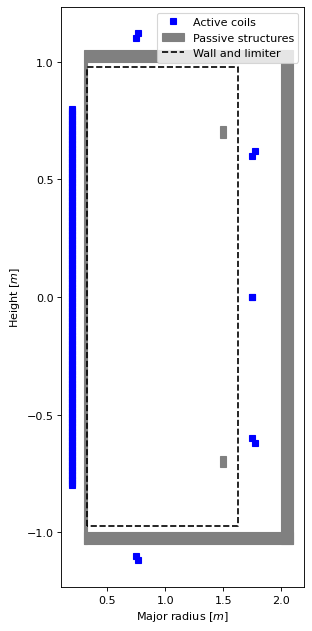

In [17]:
fig, ax = plt.subplots(figsize=(4, 8), dpi=80)

# Active coils
def plot_active_coil(ax, coil, label=None):
    ax.plot(coil["R"], coil["Z"], c="blue", marker="s", ls="", label=label)


for coil in ["P1", "P2"]:
    plot_active_coil(ax, active_coils_dict[coil]["upper"])
    plot_active_coil(ax, active_coils_dict[coil]["lower"])
plot_active_coil(ax, active_coils_dict["Pz"])
plot_active_coil(ax, active_coils_dict["Solenoid"], label='Active coils')


# Passive structure
for i, p in enumerate(passive_coils):
    if np.size(p['R'])>1:
        rect = Polygon(np.concatenate((np.array(p['R'])[:,np.newaxis], 
                                       np.array(p['Z'])[:,np.newaxis]), axis=1), color='grey',
        label='Passive structures' if i==0 else None
        )
    else:
        rect = Rectangle(
            (p["R"]-0.5*p["dR"], p["Z"]-0.5*p["dZ"]),
            p["dR"],
            p["dZ"], color='grey',
            label='Passive structures' if i==0 else None
        )
    ax.add_patch(rect)

# Limiter
ax.plot(
    [l["R"] for l in limiter] + [limiter[0]["R"]],
    [l["Z"] for l in limiter] + [limiter[0]["Z"]],
    c='k',
    ls='--',
    label='Wall and limiter'
)

ax.set_xlabel(r'Major radius [$m$]')
ax.set_ylabel(r'Height [$m$]')
ax.legend(loc='upper right')
plt.tight_layout()  # adjust subplots to fit into the figure area without overlapping
plt.show()

## Optional initialization equilibrium

It can be convenient to use a reference equilibrium that is representative for the machine that is being used. This may reduce computation times when seeking new Grad-Shafranov solutions.

It is therefore possible to provide an initial equilibrium as part of the machine description. If this is done, the provided information (values for a set of coil currents and for the plasma flux function) will be used when initializing new equilibria.

This information should be provided in the form of a dictionary. The code below illustrates the structure of such dictionary. 
In this case, we are assuming the equilibrium being saved is relevant to MAST-U.
Here `eq` is the reference equilibrium itself, which is assumed to be a solution of the GS equation. Please see Example_1 for more details on equilibrium objects and how to make sure they are GS solutions. 

```python
dictionary = {}
dictionary['coil_currents'] = eq.tokamak.getCurrents()
dictionary['plasma_psi'] = eq.plasma_psi

# save equilibrium info to file
import pickle
with open(
    'simple_initilization_equilibrium.pickle', 'wb') as f:
    pickle.dump(obj=dictionary, file=f)
```